In [2]:
from solver import *
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
%matplotlib widget

In [3]:
a0 = 1
g0 = 1e5 / 0.511
chi0 = 0.02

a0s = a0 * g0 / chi0
omega = mc2 / hbar / a0s
lamda = 2 * np.pi * c / omega

Wrad_tot, _ = calc_u_integrals(chi0)
Wrad_tot *= alpha * a0s / g0
dt = 1e-2 / Wrad_tot

A = 8 * np.sqrt(3) / 15
tc = 1 / a0s
trel = A * tc / alpha / g0 / g0 * np.power(a0s / a0, 3)

N_steps = int(4 * trel / dt)

fields = lambda t, x, y, z: (0, 0, 0, 0, 0, a0)
smf_kwargs = dict(dt = dt,
                  r0 = np.array([0, 0, 0]),
                  u0 = np.array([g0, 0, 0]),
                  t0 = 0,
                  lamda = lamda,)

N_particles = 2500

In [4]:
smf_solver = jitify_solve(fields = fields)

In [5]:
sol_mix =  process_solution(smf_solver(**smf_kwargs, 
                                       s0 = np.array([0, 0, 0]),
                                       steps = N_steps,
                                       n_out = int(1e4),
                                       n_particles = N_particles,
                                       rf_scheme = 3,
                                       progress = True))

  0%|          | 0/2500 [00:00<?, ?it/s]

In [6]:
sol_mix_no_recoil =  process_solution(smf_solver(**smf_kwargs,
                                                 s0 = np.array([0, 0, 0]),
                                                 steps = N_steps,
                                                 n_out = int(1e4),
                                                 n_particles = N_particles,
                                                 rf_scheme = 3,
                                                 progress = True,
                                                 recoil = False))

  0%|          | 0/2500 [00:00<?, ?it/s]

In [7]:
sol_pure1 = process_solution(smf_solver(**smf_kwargs, 
                                        s0 = np.array([0, 0, 1]),
                                        steps = N_steps,
                                        n_out = int(1e4),
                                        n_particles = int(N_particles/2),
                                        rf_scheme = 2,
                                        progress = True))

  0%|          | 0/1250 [00:00<?, ?it/s]

In [8]:
sol_pure2 = process_solution(smf_solver(**smf_kwargs, 
                                        s0 = np.array([0, 0, -1]),
                                        steps = N_steps,
                                        n_out = int(1e4),
                                        n_particles = int(N_particles/2),
                                        rf_scheme = 2,
                                        progress = True))

  0%|          | 0/1250 [00:00<?, ?it/s]

In [9]:
sol_pure2 = sol_pure2.assign_coords(coords = {'n': sol_pure2.n + int(N_particles/2)})
sol_pure = xr.concat((sol_pure1, sol_pure2), dim='n')

In [10]:
sol_pure_no_recoil1 = process_solution(smf_solver(**smf_kwargs, 
                                                  s0 = np.array([0, 0, 1]), 
                                                  steps = N_steps,
                                                  n_out = int(1e4),
                                                  n_particles = int(N_particles/2),
                                                  rf_scheme = 2,
                                                  progress = True,
                                                  recoil = False))

  0%|          | 0/1250 [00:00<?, ?it/s]

In [11]:
sol_pure_no_recoil2 = process_solution(smf_solver(**smf_kwargs, 
                                                  s0 = np.array([0, 0, -1]), 
                                                  steps = N_steps,
                                                  n_out = int(1e4),
                                                  n_particles = int(N_particles/2),
                                                  rf_scheme = 2,
                                                  progress = True,
                                                  recoil = False))

  0%|          | 0/1250 [00:00<?, ?it/s]

In [12]:
sol_pure_no_recoil2 = sol_pure_no_recoil2.assign_coords(coords = {'n': sol_pure_no_recoil2.n + int(N_particles/2)})
sol_pure_no_recoil = xr.concat((sol_pure_no_recoil1, sol_pure_no_recoil2), dim='n')

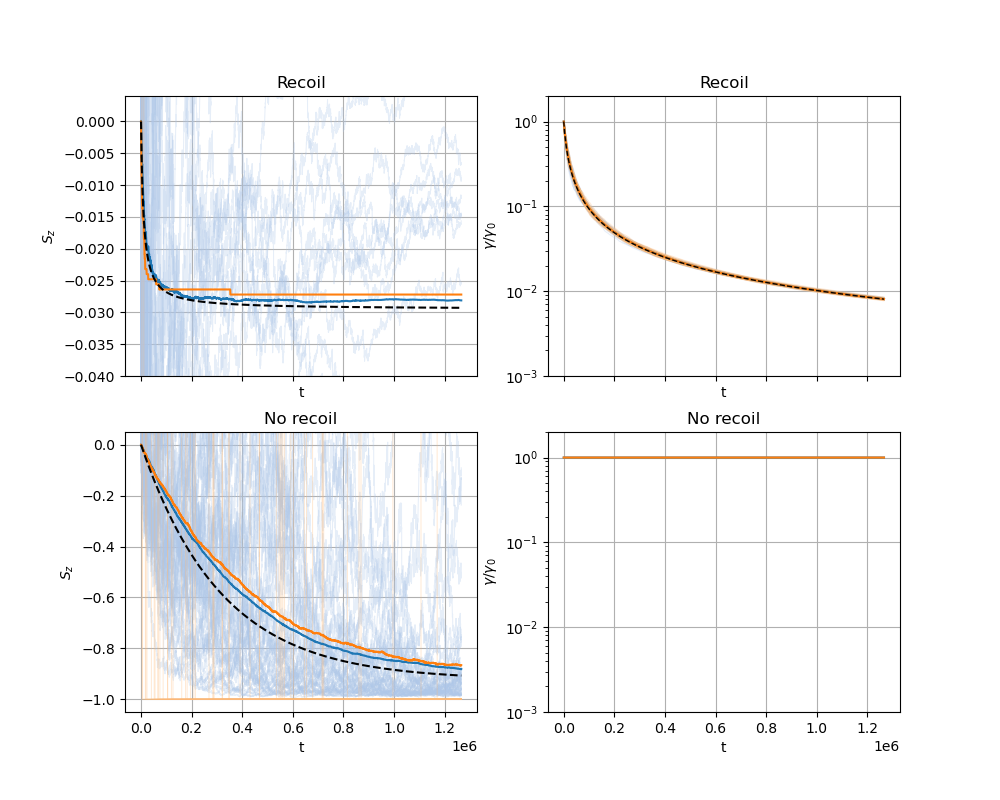

In [14]:
plt.close('all')
fig, axes = plt.subplots(2, 2, figsize=(10,8), sharex=True)

for j, sol in enumerate([sol_mix, sol_pure, sol_mix_no_recoil, sol_pure_no_recoil]):
    mask = sol.t > 0
    mask[0] = True
    sol = sol.where(mask)
    row = j//2
    column = j%2
    for i in range(50):
        track = sol.sel(n = i, drop=True)
        col = mpl.cm.tab20(2*column+1)
        axes[row][0].plot(track.t, track['sz'], c=col, alpha=0.3, lw=0.75)
        axes[row][1].plot(track.t, track['g']/track['g'][0], c=col,alpha=0.3, lw=0.75)

    av_track = sol.mean(dim = 'n')
    col = mpl.cm.tab10(column)
    axes[row][0].plot(av_track.t, av_track['sz'], c=col, lw=1.5, zorder=1000)
    axes[row][1].plot(av_track.t, av_track['g']/av_track['g'][0], c=col, lw=1.5, zorder=1000)

for i, ax in enumerate(np.ravel(axes)):
    ax.grid()
    ax.set_xlabel("t")
    ax.set_title(["Recoil", "No recoil"][i//2])
    if i % 2:
        ax.set_ylabel(r"$\gamma/\gamma_0$")
        ax.set_yscale('log')
        ax.set_ylim(1e-3, 2)
    else:
        ax.set_ylabel(r"$S_z$")
        ax.set_ylim([(-2*chi0,0.2*chi0), (-1.05,0.05)][i//2])
        

ts = np.linspace(0, float(sol.t.max()), 2500)
gg0 = 1 / (1 + ts * chi0 * 2 / 3 * alpha * a0)

ax = axes[0][0]
ax.plot(ts, -A*(1 - np.exp(-ts/trel*gg0)),'--k',zorder=2000,lw=1.5)

ax = axes[1][0]
ax.plot(ts, -A*(1 - np.exp(-ts/trel)),'--k',zorder=2000,lw=1.5)
ax.set_ylabel(r"$S_z$")

ax = axes[0][1]
ax.plot(ts, gg0, '--k', zorder=2000,lw=1)